In [1]:
# importing the necessary libraries:
import warnings
warnings.filterwarnings("ignore")
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
import leidenalg
import harmonypy as hm

In [2]:
merged = sc.read_h5ad('../data/from_arnolda/merged.h5ad')
print(merged.shape)

(52106, 27429)


In [3]:
# Subset to neutrophils only
mask = merged.obs["cell_type"].astype(str).str.strip().str.lower().eq("neutrophils".lower())
merged_neutro = merged[mask].copy()

# Clean up categories if column is categorical
if merged_neutro.obs["cell_type"].dtype.name == "category":
    merged_neutro.obs["cell_type"] = merged_neutro.obs["cell_type"].cat.remove_unused_categories()

# Sanity check
print("cell_type unique values:", merged_neutro.obs["cell_type"].unique())
print("Shape after subsetting:", merged_neutro.shape)

cell_type unique values: ['Neutrophils']
Categories (1, object): ['Neutrophils']
Shape after subsetting: (34978, 27429)


In [4]:
merged_neutro.write("../scripts/merged_neu.h5ad")

In [5]:
merged_neu = sc.read_h5ad('../scripts/merged_neu.h5ad')

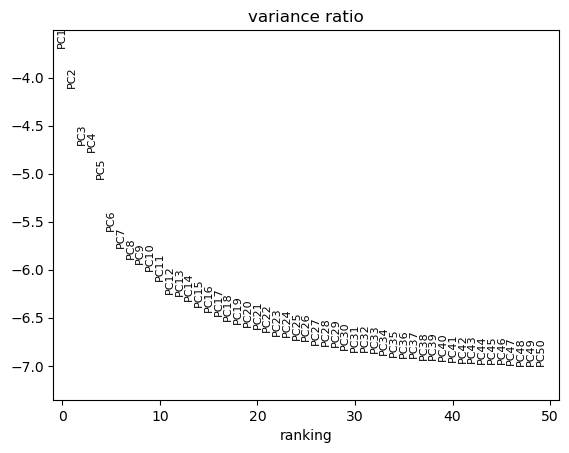

In [6]:
sc.pp.highly_variable_genes(merged_neu, n_top_genes=2000, batch_key="sample")
merged_neu = merged_neu[:, merged_neu.var['highly_variable']].copy()
sc.pp.scale(merged_neu, max_value=10)
sc.tl.pca(merged_neu, use_highly_variable=True)
sc.pl.pca_variance_ratio(merged_neu, n_pcs=50, log=True)

In [7]:
# Harmony on PCs
hres = hm.run_harmony(merged_neu.obsm['X_pca'], merged_neu.obs, 'sample')
merged_neu.obsm['X_pca_harmony'] = hres.Z_corr.T

2025-09-15 00:39:01,296 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-15 00:39:04,000 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-15 00:39:04,065 - harmonypy - INFO - Iteration 1 of 10
2025-09-15 00:39:07,549 - harmonypy - INFO - Iteration 2 of 10
2025-09-15 00:39:11,237 - harmonypy - INFO - Converged after 2 iterations


In [8]:
print(merged_neu.obsm['X_pca'].shape, merged_neu.obsm['X_pca_harmony'].shape)  # (cells, PCs) both
sc.pp.neighbors(merged_neu, use_rep='X_pca_harmony', n_neighbors=15)
sc.tl.umap(merged_neu, random_state=0)
sc.tl.leiden(merged_neu, resolution=0.3)

(35065, 50) (35065, 50)


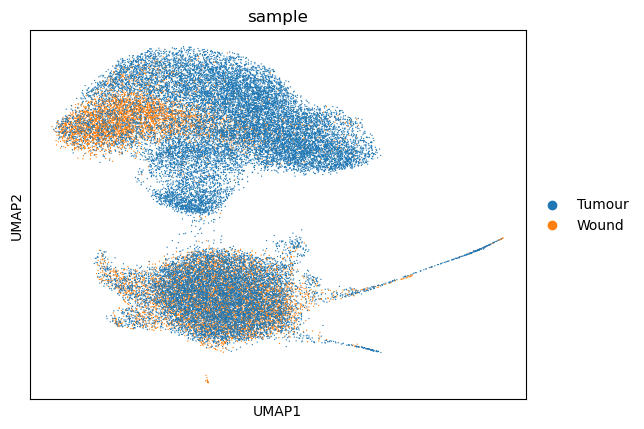

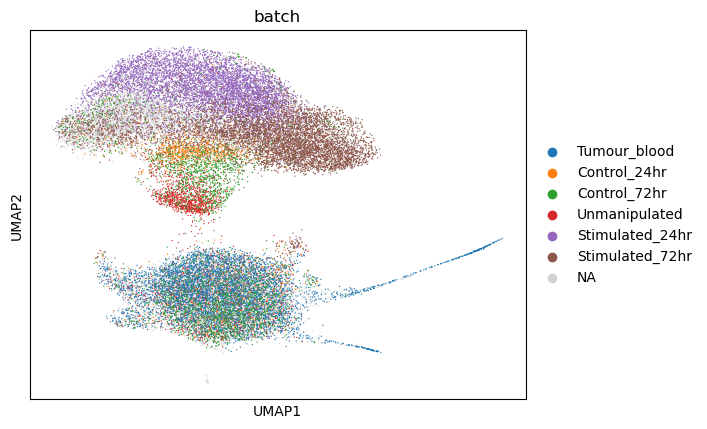

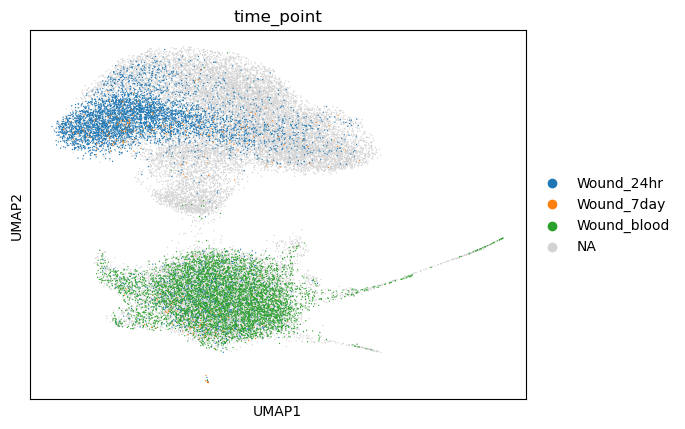

In [9]:
merged
sc.pl.umap(merged_neu, color=['sample'])
sc.pl.umap(merged_neu, color=['batch'])
sc.pl.umap(merged_neu, color=['time_point'])